# AIoT Project

In [1]:
import os

# basic data engineering
import pandas as pd
import numpy as np
import scipy

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# db
import pymongo

# configs & other
import yaml
from tqdm.notebook import tqdm_notebook
from datetime import datetime
from time import time

from psynlig import pca_explained_variance_bar

# utils processing
from utils import sliding_window_pd
from utils import apply_filter
from utils import filter_instances
from utils import flatten_instances_df
from utils import df_rebase
from utils import rename_df_column_values

# utils visualization
from utils_visual import plot_instance_time_domain
from utils_visual import plot_instance_3d
from utils_visual import plot_np_instance
from utils_visual import plot_heatmap
from utils_visual import plot_scatter_pca

#mine
from sklearn.preprocessing import LabelEncoder


%load_ext autoreload
%autoreload 2

Start time of execution

In [2]:
time_start = time()

## Load configuration

In [3]:
config_path = os.path.join(os.getcwd(), "config.yml")

with open(config_path) as file:
    config = yaml.load(file, Loader=yaml.FullLoader)

In [4]:
client = pymongo.MongoClient(config["client"])

In [5]:
db = client[config["db"]]
coll = db[config["col"]]

In [6]:
found_keys = coll.distinct("label")
print("Existing DB keys:", found_keys)

Existing DB keys: ['class_A', 'class_D', 'class_L', 'class_M', 'class_U']


## Load data

Saved class_A.csv successfully.
Saved class_D.csv successfully.
Saved class_L.csv successfully.
Saved class_M.csv successfully.
Saved class_U.csv successfully.
All classes exported to CSV.


C:\Users\Giannis\AppData\Local\Temp\ipykernel_7104\1938598604.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=csv_files, y=file_counts, palette='viridis')


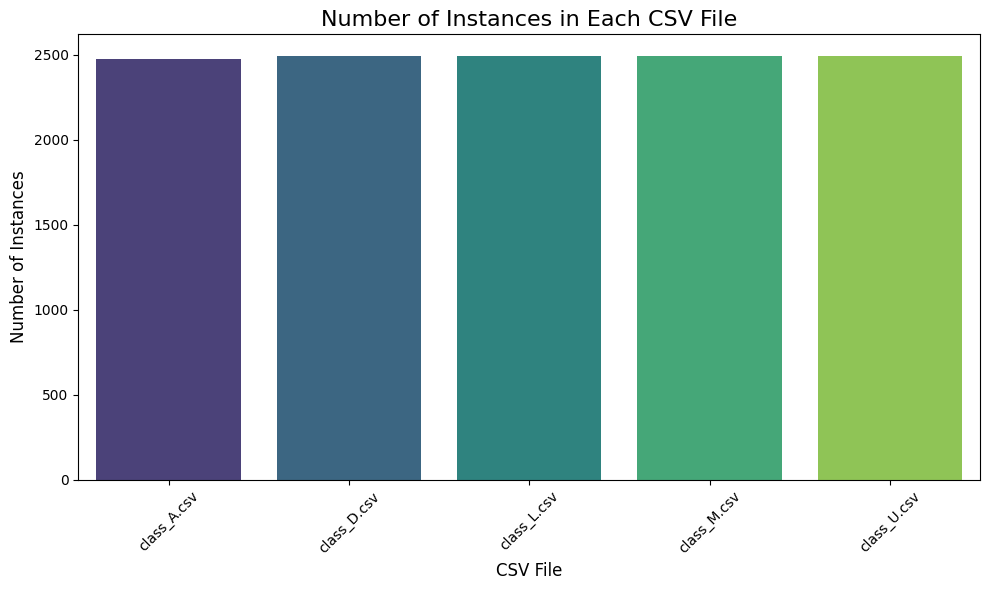

In [8]:
save_path = "loaded_data"

# Create folder if it doesn't exist
os.makedirs(save_path, exist_ok=True)

# Get documents from database 
documents = coll.find()

for doc in documents:
    label = doc["label"]  
    data = doc["data"]

    # Dataframe of the watch data
    df = pd.DataFrame({
        "acc_x": data["acc_x"],
        "acc_y": data["acc_y"],
        "acc_z": data["acc_z"],
    })

    # filename for each collection
    filename = f"{label}.csv"
    file_path = os.path.join(save_path, filename)

    # save DataFrame to CSV
    df.to_csv(file_path, index=False)

    print(f"Saved {filename} successfully.")

print("All classes exported to CSV.")

# print bar graphs for each csv file 
csv_folder = "loaded_data"
csv_files = [f for f in os.listdir(csv_folder) if f.endswith('.csv')]

# list for storing the number of instances in each CSV file
file_counts = []

# read csv and count the number of instances
for csv_file in csv_files:
    file_path = os.path.join(csv_folder, csv_file)
    df = pd.read_csv(file_path)
    file_counts.append(len(df)) 

# barplot
plt.figure(figsize=(10, 6))
sns.barplot(x=csv_files, y=file_counts, palette='viridis')

# title and labels
plt.title('Number of Instances in Each CSV File', fontsize=16)
plt.xlabel('CSV File', fontsize=12)
plt.ylabel('Number of Instances', fontsize=12)


plt.xticks(rotation=45)  
plt.tight_layout()


plt.show()


Processing class_A.csv...


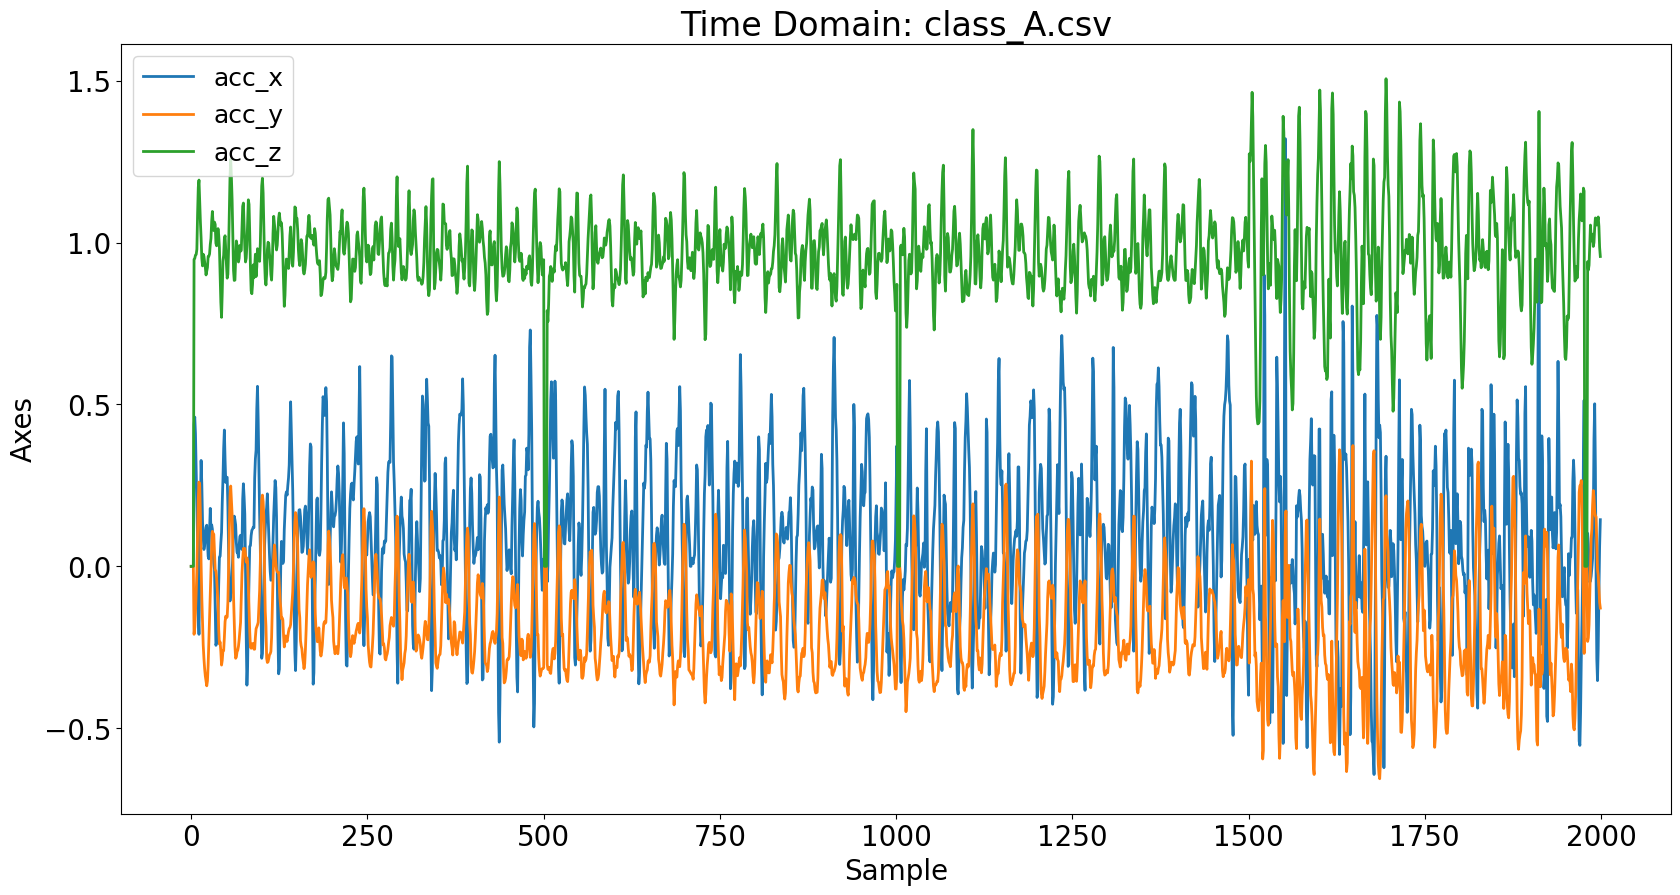

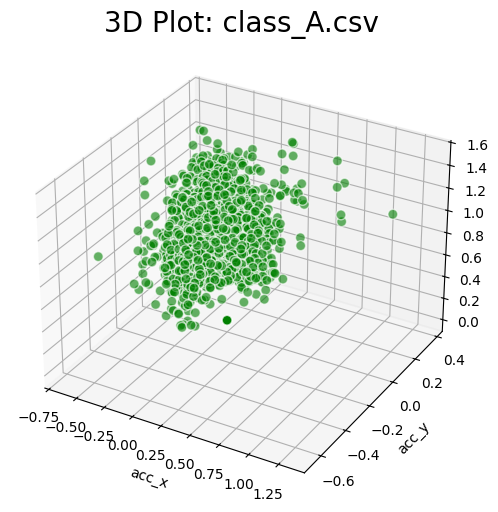

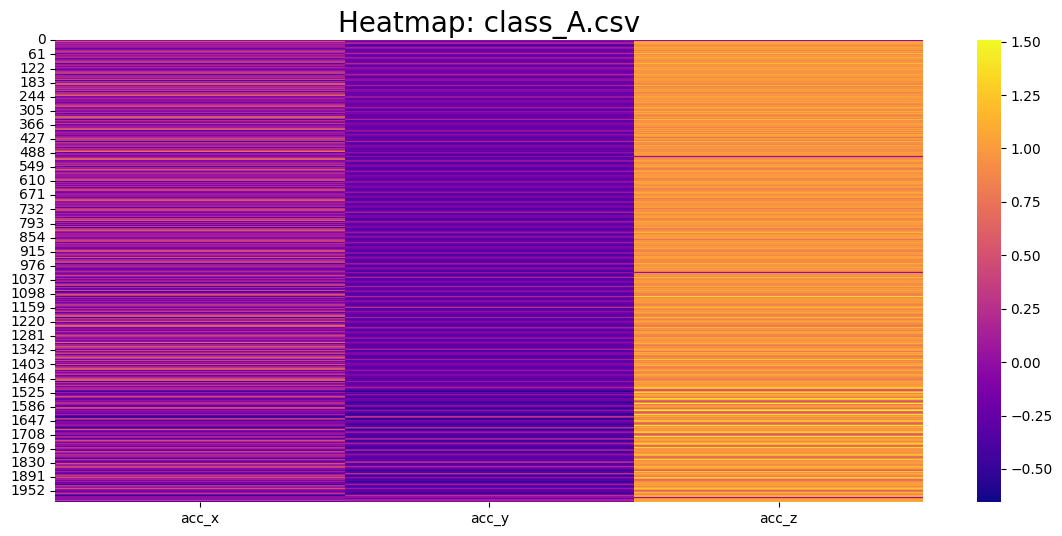

Processing class_D.csv...


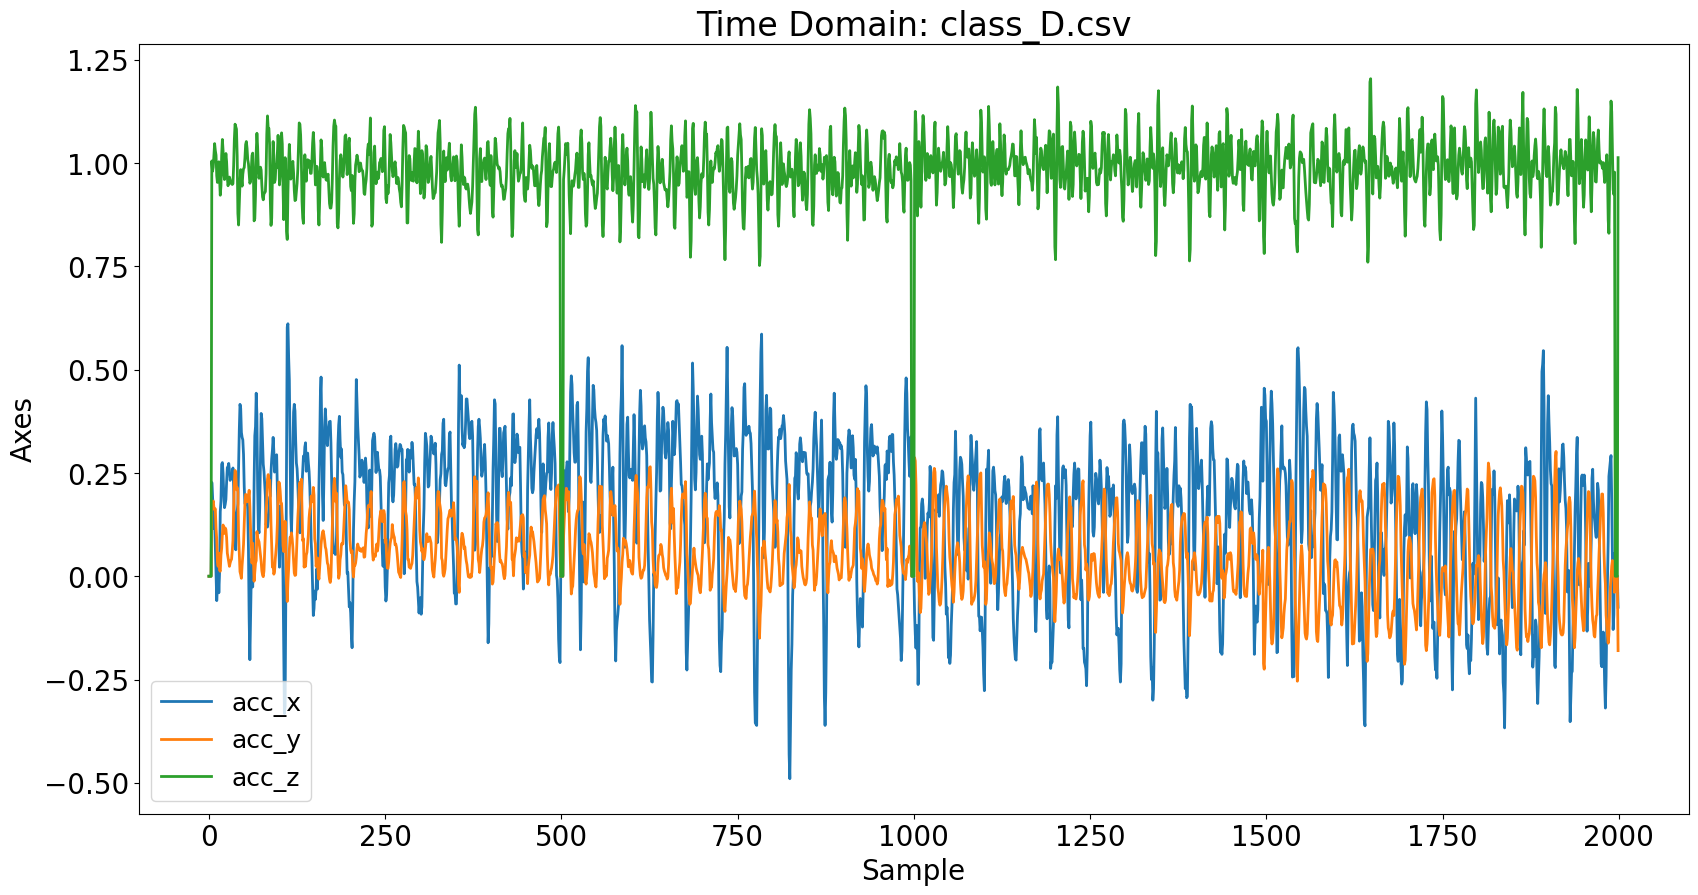

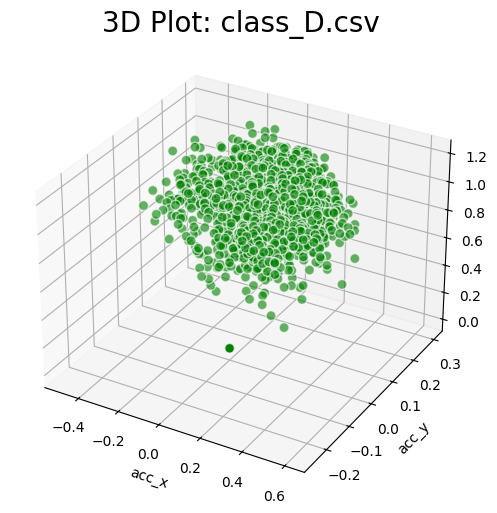

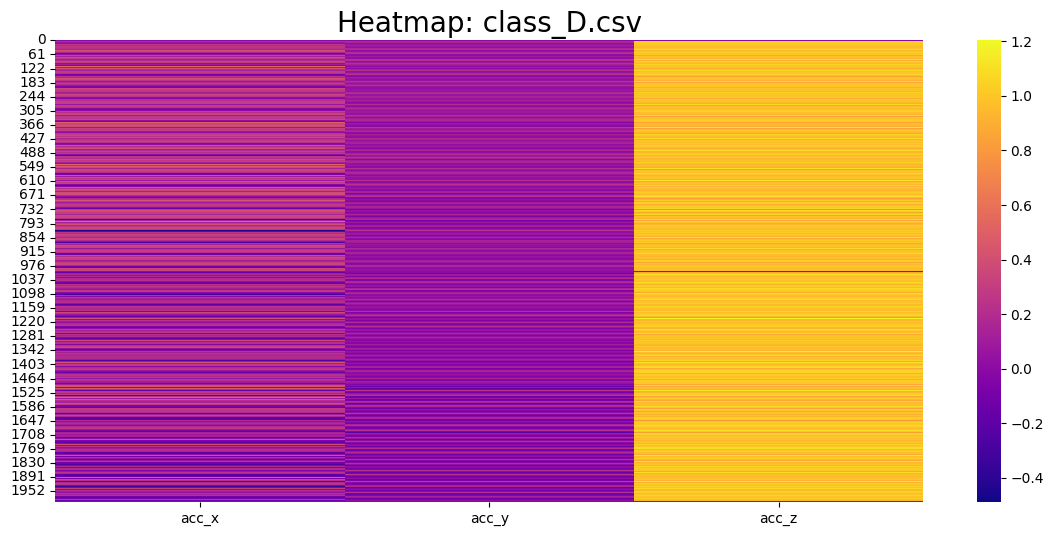

Processing class_L.csv...


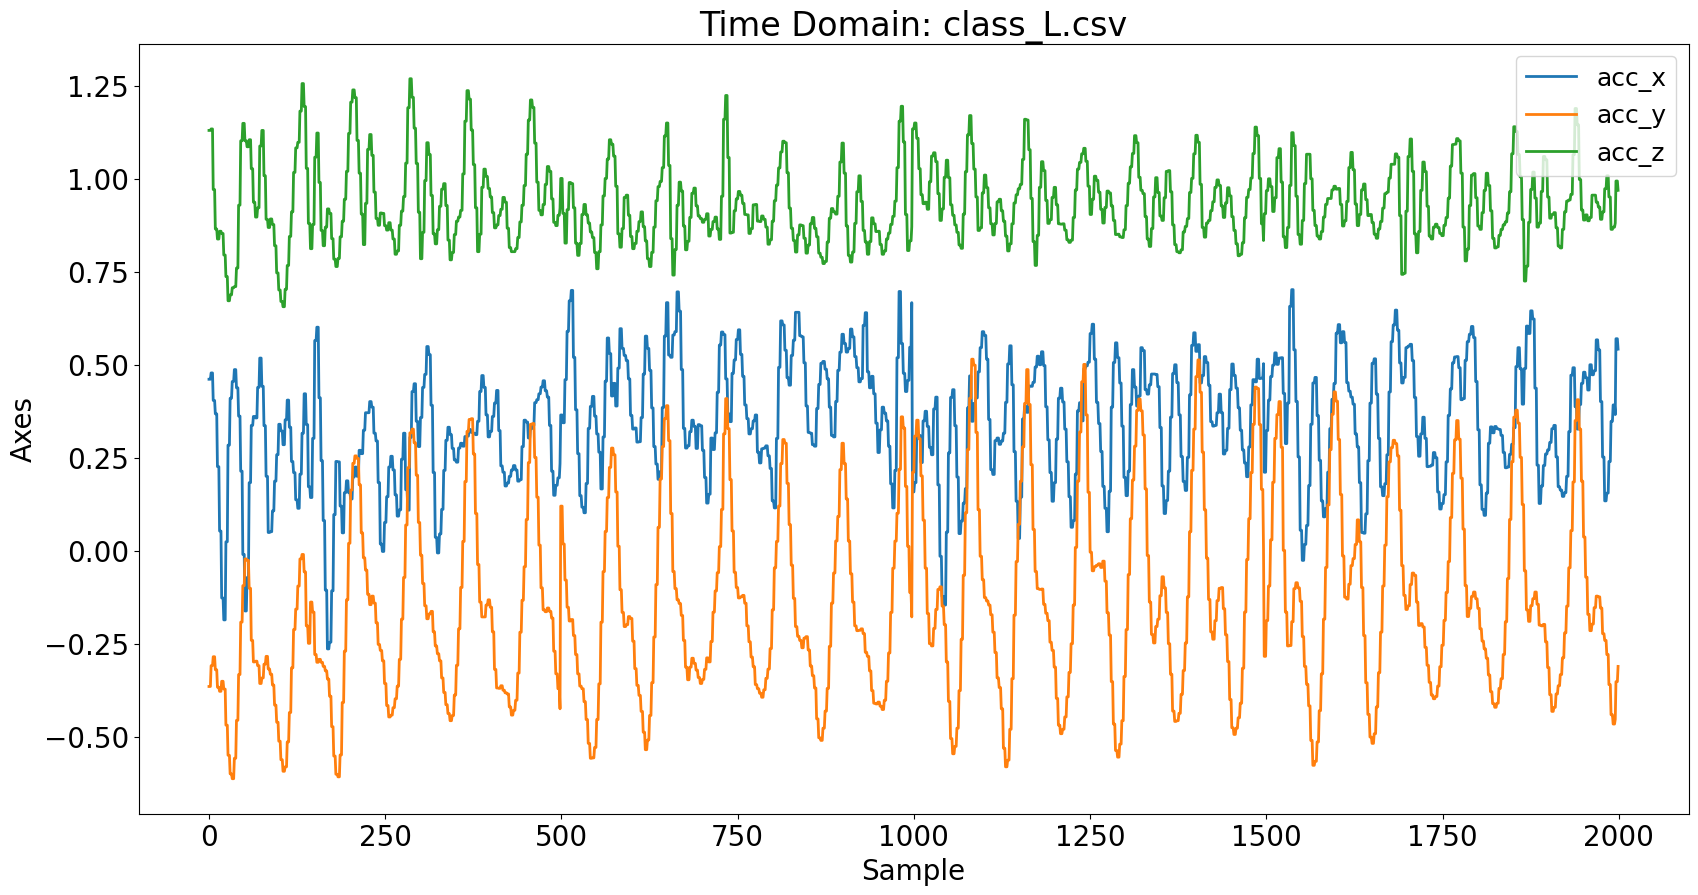

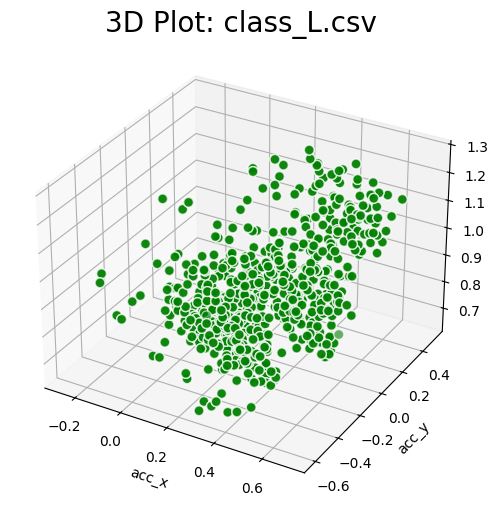

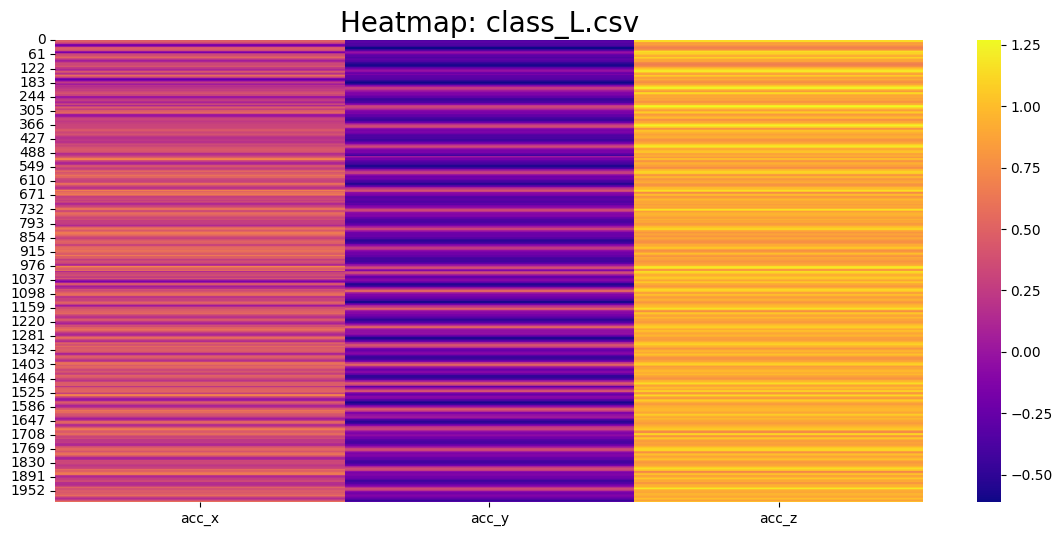

Processing class_M.csv...


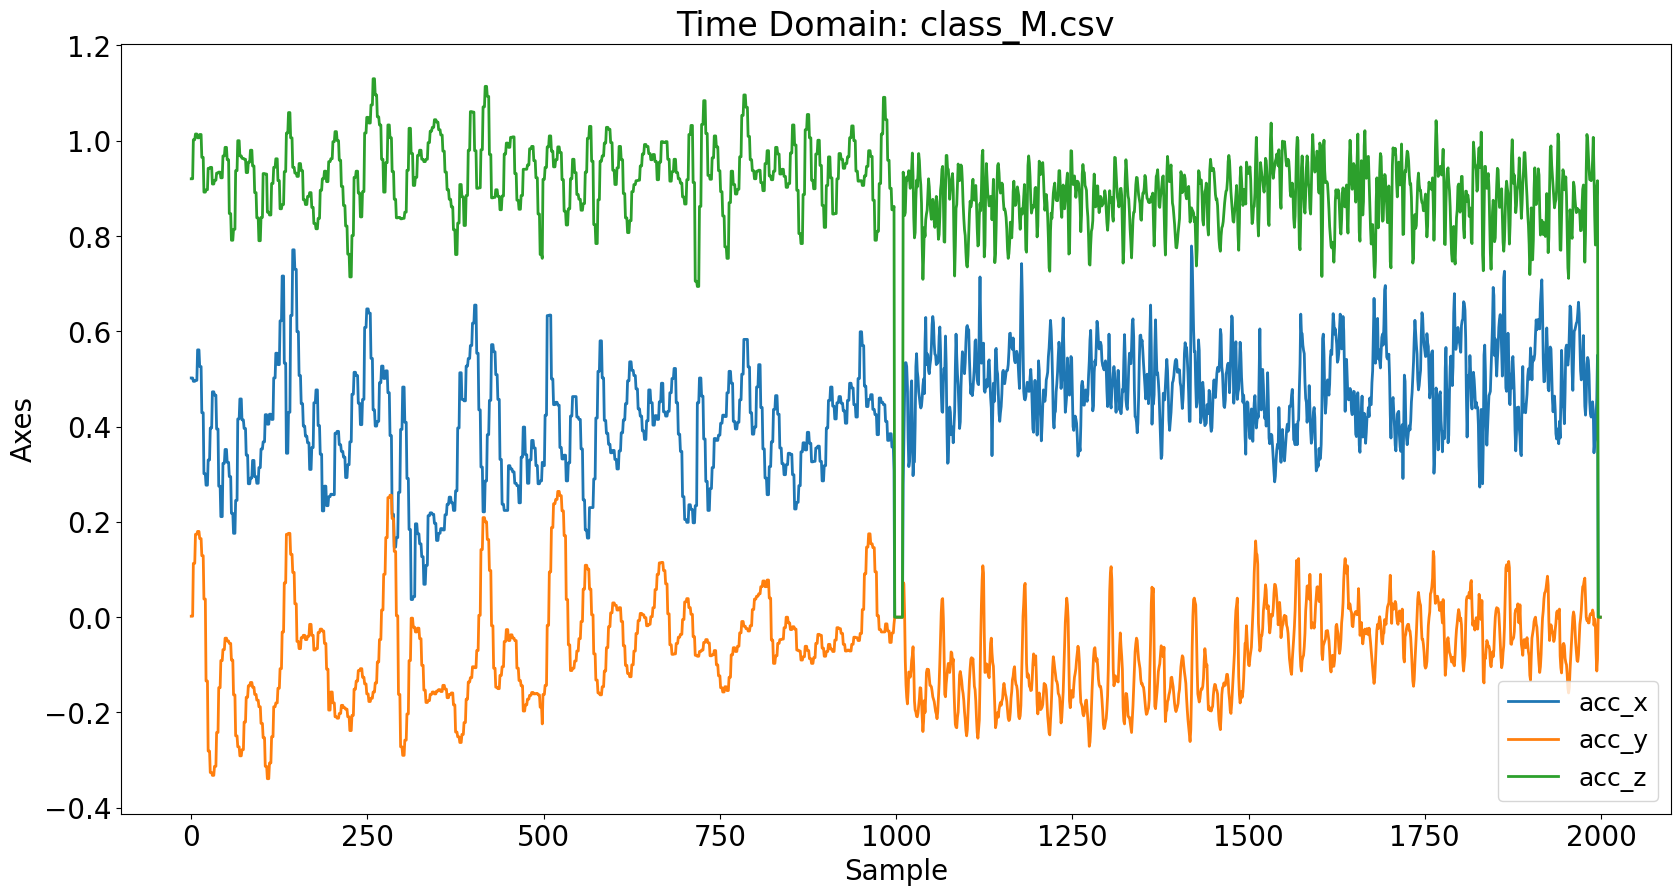

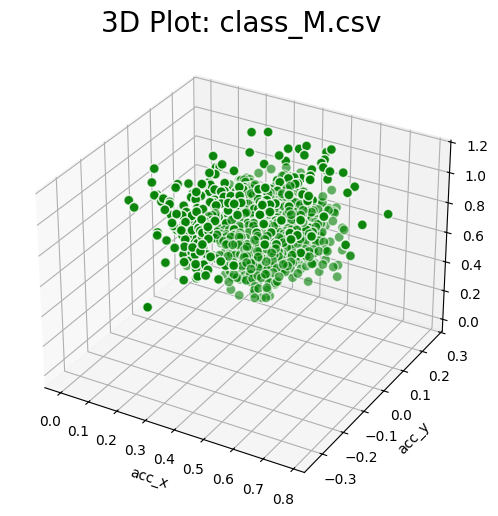

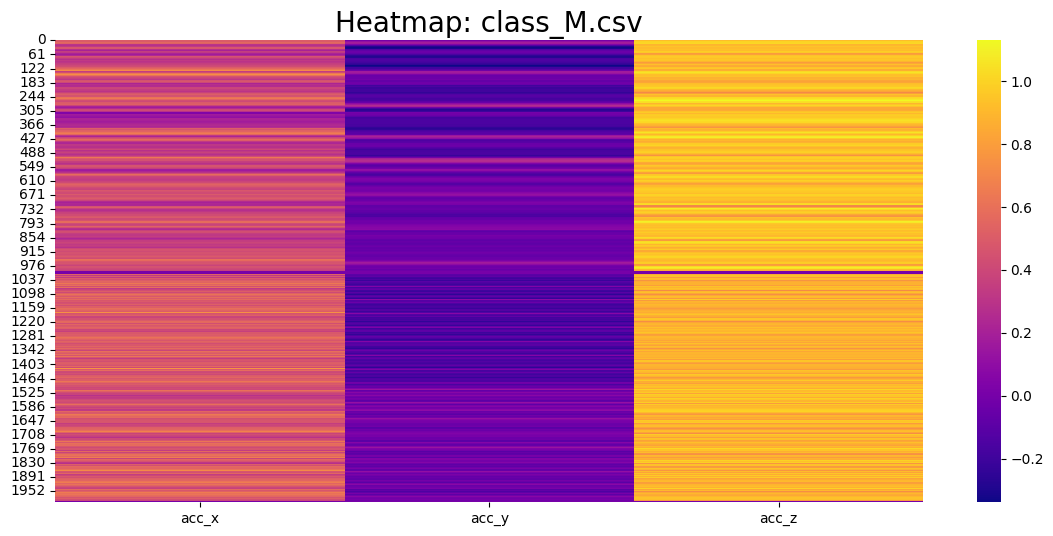

Processing class_U.csv...


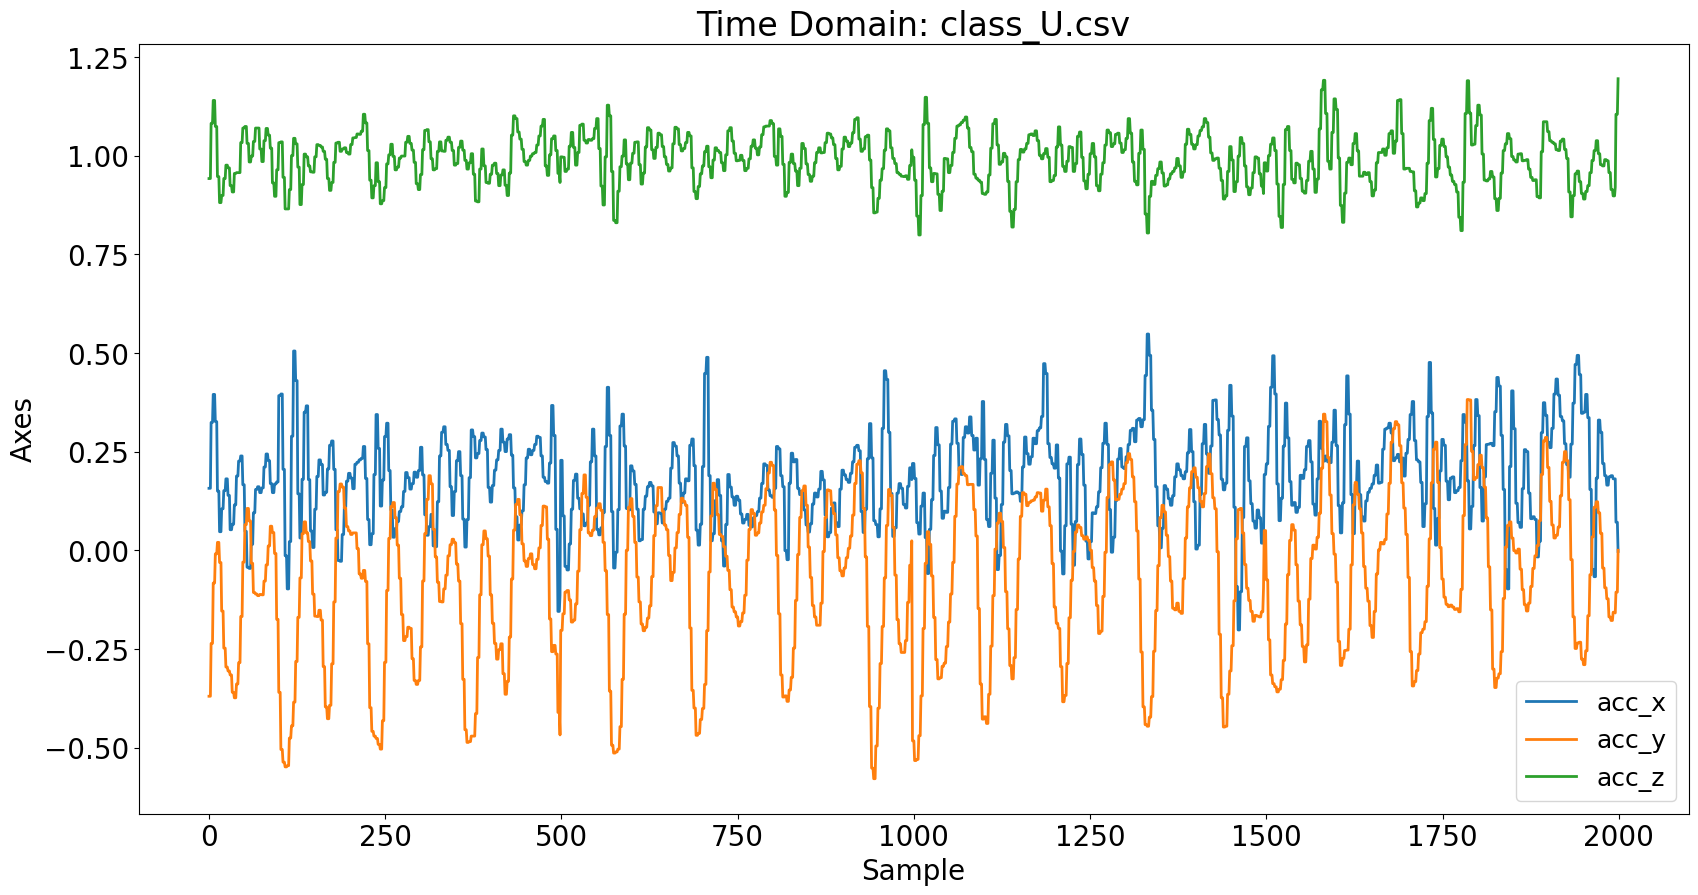

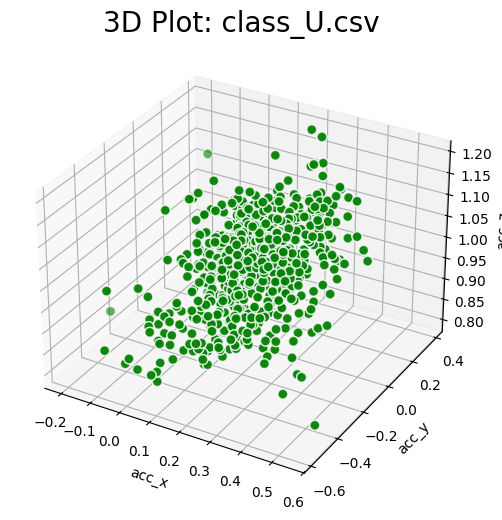

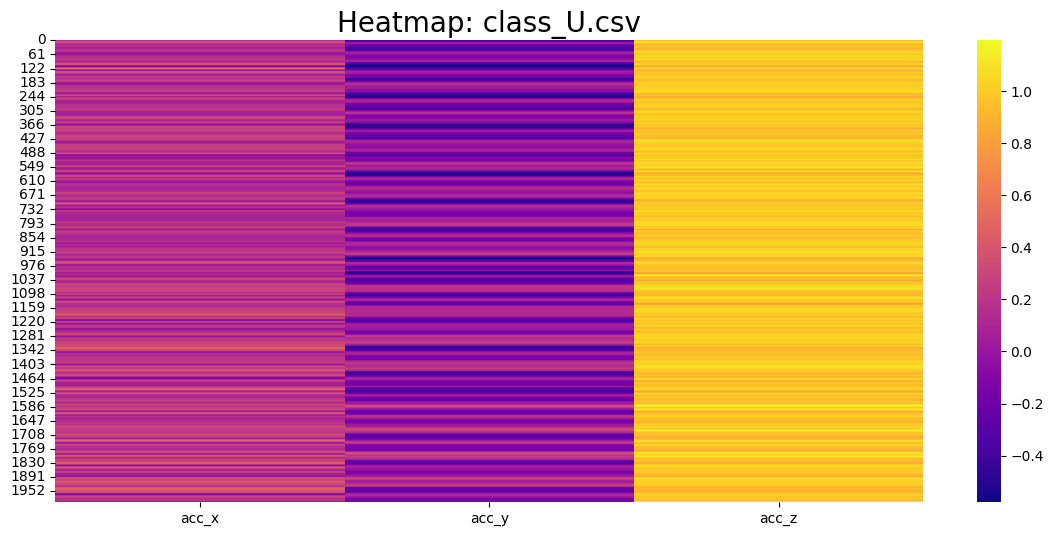

In [ ]:
csv_folder = "loaded_data"

csv_files = [f for f in os.listdir(csv_folder) if f.endswith('.csv')]


for csv_file in csv_files:
    print(f"Processing {csv_file}...")
    
    # load CSV
    file_path = os.path.join(csv_folder, csv_file)
    df = pd.read_csv(file_path)

    # keep the first 2000
    df = df.head(2000)

    # 1. plot_instance_time_domain
    plot_instance_time_domain(df)
    plt.title(f"Time Domain: {csv_file}", fontsize=24)
    plt.show()

    # 2. plot_instance_3d
    plot_instance_3d(df)
    plt.title(f"3D Plot: {csv_file}", fontsize=20)
    plt.show()

    # 3. plot_heatmap
    plot_heatmap(df)
    plt.title(f"Heatmap: {csv_file}", fontsize=20)
    plt.show()




## Explore the nature of the data

In [23]:
import os
import pandas as pd

# folder with loaded data
csv_folder = "loaded_data"

# get the files
csv_files = [f for f in os.listdir(csv_folder) if f.endswith('.csv')]

# list for the windows of each class
all_windows = {}

# for each csv file, load the data and apply sliding window
for csv_file in csv_files:
    file_path = os.path.join(csv_folder, csv_file)
    
    # load the csv file
    df = pd.read_csv(file_path)
    
    # sliding window
    windows = sliding_window_pd(df[['acc_x', 'acc_y', 'acc_z']], ws=100, overlap=50)
    
    # remove the .csv extension
    file_name_no_ext = os.path.splitext(csv_file)[0]
    
    # save the windows in the dictionary
    all_windows[file_name_no_ext] = windows

# length of the windows for each csv file
for file_name, windows in all_windows.items():
    print(f"{file_name}: {len(windows)} windows")



class_A: 48 windows
class_D: 48 windows
class_L: 48 windows
class_M: 48 windows
class_U: 48 windows


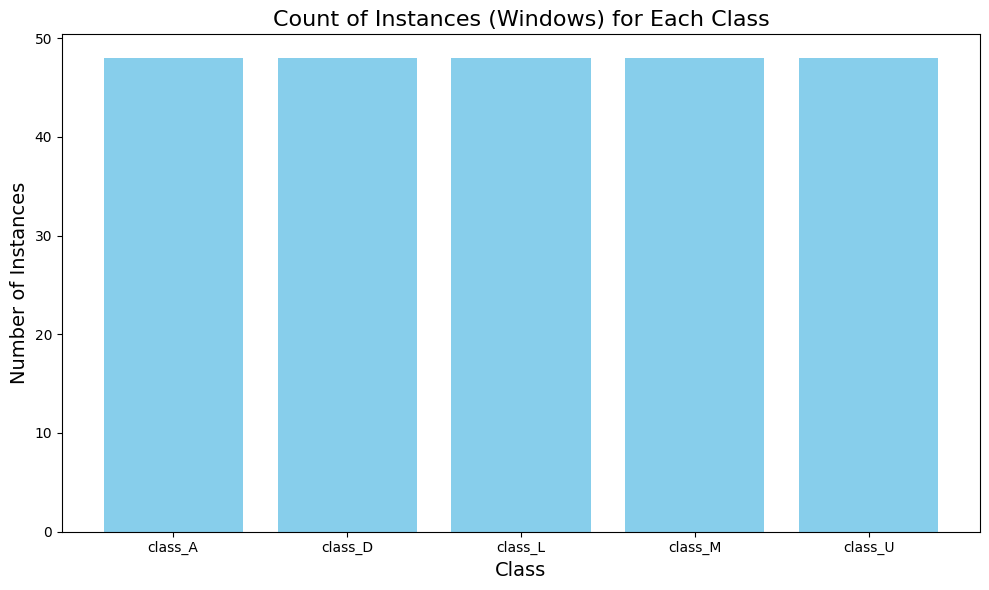

In [24]:
# print number of windows for each class
class_counts = {csv_file: len(windows) for csv_file, windows in all_windows.items()}

# Barplot
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')

# title and labels
plt.title('Count of Instances (Windows) for Each Class', fontsize=16)
plt.xlabel('Class', fontsize=14)
plt.ylabel('Number of Instances', fontsize=14)


plt.tight_layout()
plt.show()

## Apply filter

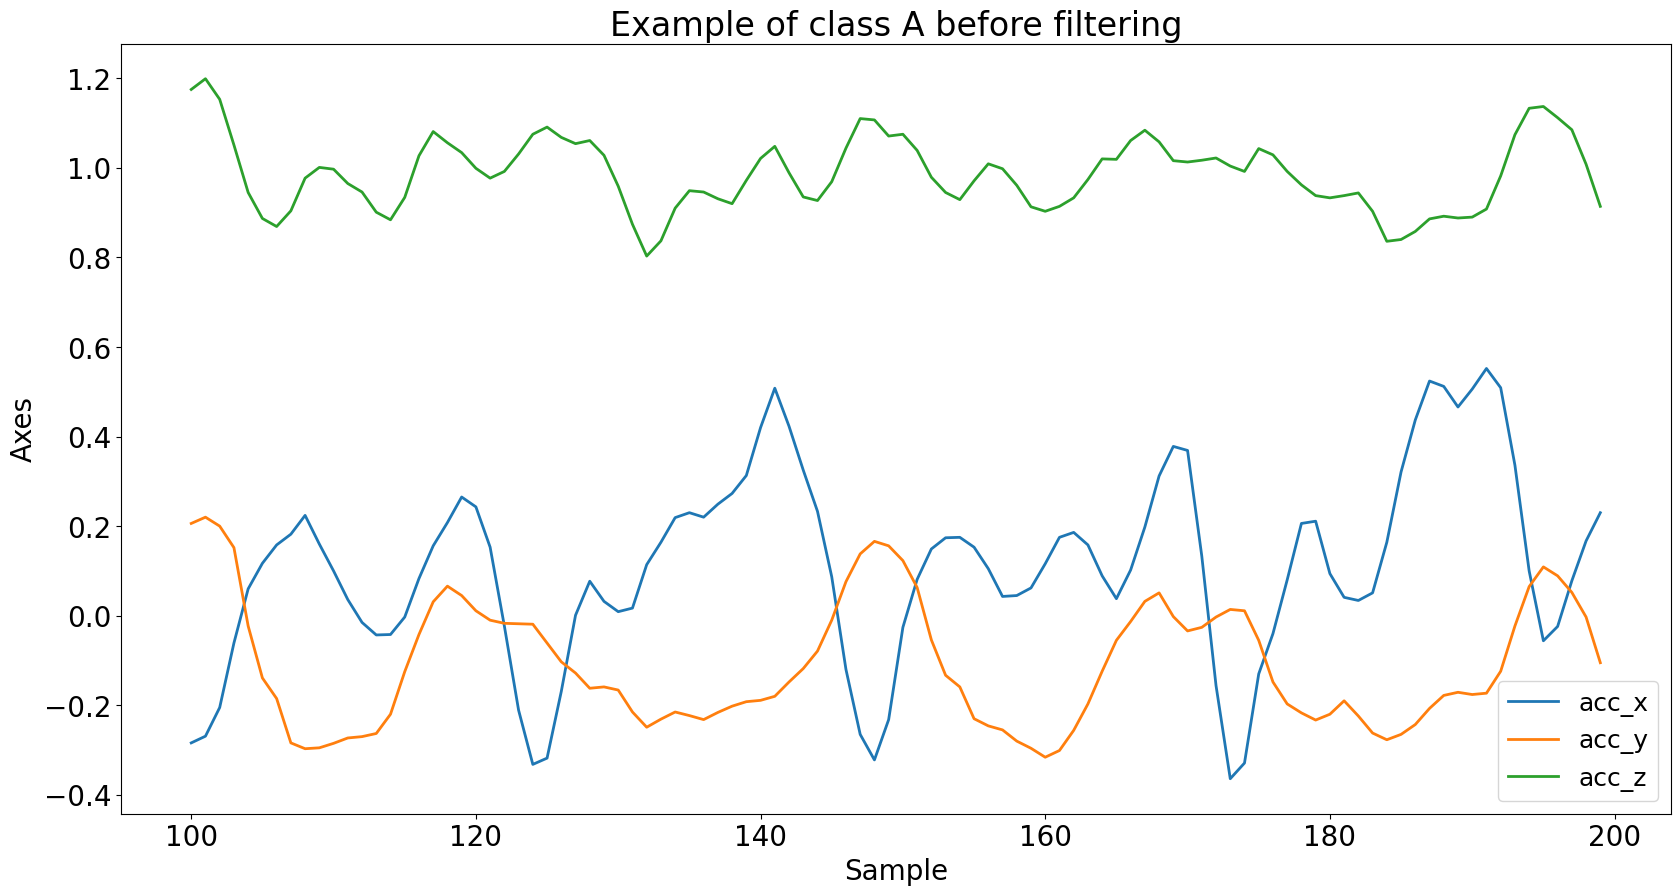

Number of filtered instances in the list: 48
Number of filtered instances in the list: 48
Number of filtered instances in the list: 48
Number of filtered instances in the list: 48
Number of filtered instances in the list: 48


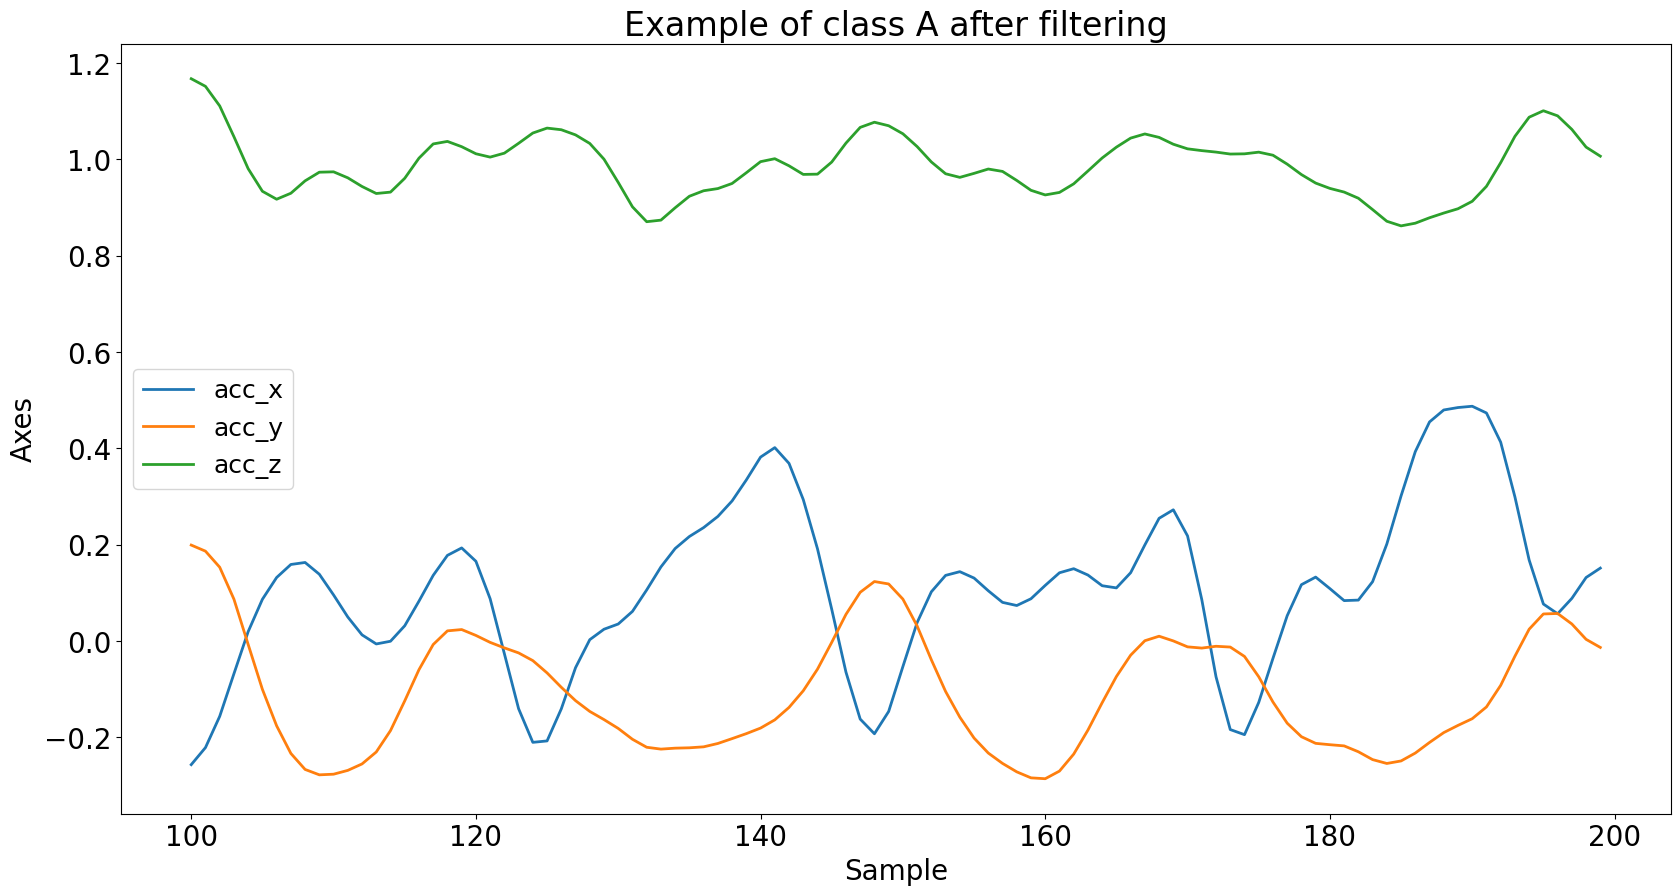

In [25]:
from utils_visual import plot_instance_time_domain
filtered_windows = {}

plot_instance_time_domain(all_windows['class_A'][2])
plt.title("Example of class A before filtering", fontsize=24)
plt.show()

# lowpass filter
order = 1  # order of the filter
wn = 0.25   # normalized cutoff frequency (0.1 corresponds to 10% of the Nyquist frequency)
filter_type = "lowpass"  # type of filter

#   for each class, apply the filter to the windows
for class_name, windows in all_windows.items():
    filtered_windows[class_name] = filter_instances(windows, order, wn, filter_type)

plot_instance_time_domain(filtered_windows['class_A'][2])
plt.title("Example of class A after filtering", fontsize=24)
plt.show()


## Transform the list of DataFrames to NumPy array

Transform the list of DataFrames to NumPy array that contains the windows: (instances, x, y)

In [26]:
all_numpy = {}

for class_name, instances_list in filtered_windows.items():
    instances_np = np.array([df.to_numpy() for df in instances_list])  # shape: (instances, time, axes)
    all_numpy[class_name] = instances_np
    print(f"{class_name} shape:", instances_np.shape)

class_A shape: (48, 100, 3)
class_D shape: (48, 100, 3)
class_L shape: (48, 100, 3)
class_M shape: (48, 100, 3)
class_U shape: (48, 100, 3)


## Flatten the 2D window instances

Flatten the X NumPy array that contains the 2D window instances

In [ ]:
X_all = {}  # for the data
y_all = {}  # for the labels


for class_name, instances_list in filtered_windows.items():
    X_class = []
    y_class = []
    
    # flatten each window and append to the list
    for df in instances_list:
        flat_instance = df.to_numpy().flatten()
        X_class.append(flat_instance)
        y_class.append(class_name)
    
    # save the flattened instances and labels
    X_all[class_name] = X_class
    y_all[class_name] = y_class

#print("Class A Flatten:")
#print(pd.DataFrame(X_all['class_A']))

# save the data into a single csv.

all_data = []

for class_name, instances_list in filtered_windows.items():
    for df in instances_list:
        flat_instance = df.to_numpy().flatten()
        instance_with_class = [class_name] + flat_instance.tolist()
        all_data.append(instance_with_class)

columns = ['Class'] + [f'Feature_{i+1}' for i in range(len(all_data[0]) - 1)]
df_all = pd.DataFrame(all_data, columns=columns)

# Folder containing the train data
csv_folder2 = "train_data"

# Create folder if it doesn't exist
os.makedirs(csv_folder2, exist_ok=True)

df_all.to_csv('train_data/flattened_data.csv', index=False)

print(df_all.head())



     Class  Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  Feature_6  \
0  class_A   0.010685  -0.004654   0.023952   0.025796  -0.011235   0.057825   
1  class_A   0.250410  -0.140821   0.926244   0.215634  -0.115733   0.929215   
2  class_A  -0.256737   0.199123   1.167338  -0.221287   0.186498   1.151531   
3  class_A   0.022800   0.078360   1.051560   0.069653   0.027656   1.025867   
4  class_A   0.170442  -0.155454   0.895676   0.155380  -0.179618   0.912323   

   Feature_7  Feature_8  Feature_9  ...  Feature_291  Feature_292  \
0   0.062277  -0.027124   0.139603  ...     0.964130     0.190358   
1   0.150317  -0.066192   0.953905  ...     1.034759    -0.179355   
2  -0.156459   0.153161   1.110897  ...     1.090271     0.088468   
3   0.115183  -0.040524   0.994266  ...     1.081462    -0.042185   
4   0.148711  -0.211335   0.934831  ...     0.987729     0.129503   

   Feature_293  Feature_294  Feature_295  Feature_296  Feature_297  \
0    -0.064139     0.974299     0.

## Train/Test split

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
df_all = pd.read_csv('train_data/flattened_data.csv')


X = df_all.drop(columns=['Class'])  
y = df_all['Class']  


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True, random_state=42)


In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

model = RandomForestClassifier(random_state=5)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 85.42%


## Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

## Transform to 2D again

## Dimensionality Reduction with PCA using the 1D (flattened) data

In [ ]:
# add transformers
from sklearn.decomposition import PCA

### PCA with 2 Components

In [ ]:
pca2d.fit(data)

In [ ]:
pca_explained_variance_bar(pca_object, alpha=0.8)

In [ ]:
plot_scatter_pca()

### PCA with 3 Components

### PCA with X% of the variance of the dataset, for training the statistical AI Models

## Classifier - Statistical Learning

### Apply simple classifier

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

### Evaluate simple classifier

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
from sklearn.metrics import classification_report

### Apply optimization with Grid Search and Cross-validation

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

### Evaluate optimized classifier

## Classifier - Neural Network

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, Flatten

In [ ]:
input_data_shape = X_train_2d[0].shape
print("Type of the input shape object:", type(input_data_shape))
X_train_2d[0].shape

In [ ]:
y_np_array = np.array(y)
n_outputs = len(np.unique(y_np_array))
print("Number of outputs (classes) the model to predict:", n_outputs)

### Create the Neural Network (NN) Architecture and instantiate the model

In [ ]:
model = Sequential()

"""
BUILD YOUR MODEL ARCHITECTURE HERE
"""

model.add(Dense(n_outputs, activation="softmax"))

Plot the Architecture of ot the TensorFlow model

Plot the summary of the TensorFlow model

### Build the NN model

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["ADD METRIC"])

In [ ]:
from utils import encode_labels

### Train the NN model

### Evaluate the model on the test data

### Plot and interpret the learning curves: Loss and Accuracy based on the training and validation sets